In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-08-30 09:38:34 __main__ INFO     torch.__version__='2.7.1+cu126', torch.version.cuda='12.6'
2025-08-30 09:38:34 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-08-30 09:38:34 __main__ INFO     transformers.__version__='4.54.1'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-08-30 09:38:39 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/gio/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-30 09:38:39 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/gio/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)


In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key= "/disk/u/gio/mechinterp/models/" + model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-08-30 09:39:31 src.models INFO     loaded model </disk/u/gio/mechinterp/models/meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [5]:
from src.selection.data import SelectOneTask, SelectOrderTask

TASK_CLS = SelectOneTask
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR,
        "selection",
        "objects.json"
    )
)

print(select_task)

SelectOneTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(14)



In [6]:
sample = select_task.get_random_sample(
    mt=mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=prompt_template_idx,
    obj_idx=2,
    category="jewelry",
    filter_by_lm_prediction=False
)

print(sample)
print(sample.prompt())

Pin -> Chain (2): ['Factory', 'Onion', 'Chain', 'Piano', 'Football', 'Peach']
Options: Factory, Onion, Chain, Piano, Football, Peach.
Which among these objects mentioned above is a jewelry?
Answer:


In [7]:
from src.selection.utils import verify_correct_option

print(f'"{sample.prompt()}"', ">>", sample.obj)

verify_correct_option(
    mt=mt,
    target=sample.obj,
    options=sample.options,
    input=sample.prompt()
)

"Options: Factory, Onion, Chain, Piano, Football, Peach.
Which among these objects mentioned above is a jewelry?
Answer:" >> Chain


(True,
 [PredictedToken(token=' Chain', prob=0.94140625, logit=22.25, token_id=29625, metadata=None),
  PredictedToken(token=' The', prob=0.0152587890625, logit=18.125, token_id=578, metadata=None),
  PredictedToken(token=' A', prob=0.0081787109375, logit=17.5, token_id=362, metadata=None),
  PredictedToken(token=' Factory', prob=0.004364013671875, logit=16.875, token_id=17367, metadata=None),
  PredictedToken(token=' None', prob=0.0026397705078125, logit=16.375, token_id=2290, metadata=None)],
 OrderedDict([(29625,
               (1,
                PredictedToken(token=' Chain', prob=0.94140625, logit=22.25, token_id=29625, metadata=None))),
              (17367,
               (4,
                PredictedToken(token=' Factory', prob=0.004364013671875, logit=16.875, token_id=17367, metadata=None))),
              (87035,
               (8,
                PredictedToken(token=' Onion', prob=0.0020599365234375, logit=16.125, token_id=87035, metadata=None))),
              (56491,
   

In [8]:
from src.functional import generate_with_patch

gen = generate_with_patch(
    mt=mt,
    inputs=sample.prompt(),
    max_new_tokens=20,
    do_sample=False,
    remove_prefix=True
)[0]

print(f'"{gen}"', ">>", sample.obj)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


" Chain.
Explanation: Chain is a type of jewelry. It is a series of linked metal rings used" >> Chain


In [9]:
from matplotlib import pyplot as plt
import numpy as np

optimized_path = os.path.join(
    "/disk/u/arnab/Codes/Projects/retrieval/results",
    "selection/optimized_heads",
    mt.name.split("/")[-1],
    f"{select_task.task_name}.npz"
)

optimization_results = np.load(optimized_path, allow_pickle=True)

2025-08-30 09:44:14 matplotlib DEBUG    matplotlib data path: /disk/u/gio/.conda/envs/retrieval2/lib/python3.11/site-packages/matplotlib/mpl-data
2025-08-30 09:44:14 matplotlib DEBUG    CONFIGDIR=/disk/u/gio/.config/matplotlib
2025-08-30 09:44:14 matplotlib DEBUG    interactive is False
2025-08-30 09:44:14 matplotlib DEBUG    platform is linux
2025-08-30 09:44:14 matplotlib DEBUG    CACHEDIR=/disk/u/gio/.cache/matplotlib
2025-08-30 09:44:14 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/gio/.cache/matplotlib/fontlist-v390.json


2025-08-30 09:44:56 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-08-30 09:44:56 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-08-30 09:44:56 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-08-30 09:44:56 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/disk/u/gio/.conda/envs/retrieval2/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBolIta.ttf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2025-08-30 09:44:56 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/disk/u/gio/.conda/envs/retrieval2/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scal

(True, True)

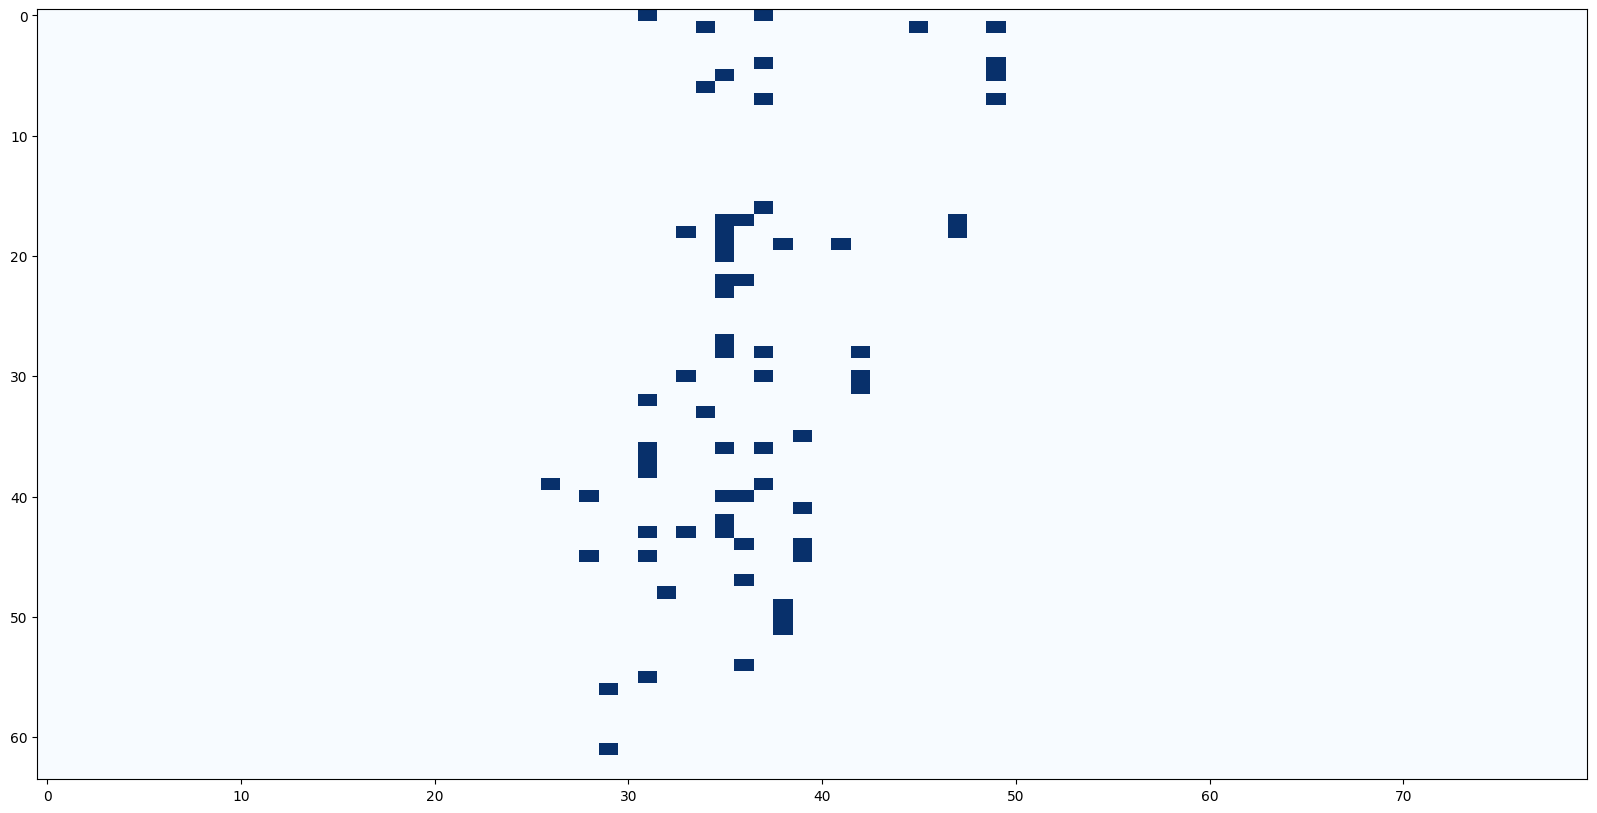

In [10]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[50:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

heads_selected = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
heads_selected = [
    (layer_idx, head_idx) for layer_idx, head_idx in heads_selected if layer_idx < 50
]
print(len(heads_selected))

HEADS = heads_selected

(35, 19) in HEADS, (35, 19) in heads_selected

In [11]:
from src.selection.functional import verify_head_patterns

attn_patterns = verify_head_patterns(
    prompt=sample.prompt(),
    options=sample.options,
    pivot=sample.subj,
    mt=mt,
    heads=HEADS
)

0 patches to ablate possible answer information from options
2025-08-30 09:46:06 src.selection.functional DEBUG    Predictions: ['" Chain"[29625] (p=0.941, logit=22.250)', '" The"[578] (p=0.015, logit=18.125)', '" A"[362] (p=0.008, logit=17.500)', '" Factory"[17367] (p=0.004, logit=16.875)', '" None"[2290] (p=0.003, logit=16.375)']
2025-08-30 09:46:06 src.selection.functional INFO     Combined attention matrix for all heads


In [12]:
import copy
import random
from src.selection.utils import KeyedSet, get_first_token_id, verify_correct_option
from src.selection.data import SelectionSample
from src.functional import predict_next_token
from src.tokens import prepare_input

######################################################################
N_DISTRACTORS = 5
WINDOW_SPEC = {
    mt.layer_name_format: 1,
    mt.mlp_module_name_format: 9,
    mt.attn_module_name_format: 9,
}
module_name_format = mt.layer_name_format
# module_name_format = mt.mlp_module_name_format
# module_name_format = mt.attn_module_name_format

######################################################################


@torch.inference_mode()
def get_counterfactual_samples_within_task(
    task: SelectOneTask | SelectOrderTask = select_task,
    patch_category: str | None = None,
    clean_category: str | None = None,
    shuffle_clean_options: bool = False,
    prompt_template_idx=2,
    clean_option_style="numbered",
    patch_option_style="single_line",
    filter_by_lm_prediction: bool = True,
    distinct_options: bool = False,
    n_distractors: int = N_DISTRACTORS,
):
    categories = list(task.category_wise_examples.keys())
    if patch_category is None:
        patch_category = random.choice(categories)

    patch_subj, patch_obj = random.sample(
        task.category_wise_examples[patch_category], 2
    )
    logger.info(
        f"Patch category: {patch_category}, subject: {patch_subj}, object: {patch_obj}"
    )

    if clean_category is None:
        clean_category = random.choice(list(set(categories) - {patch_category}))

    clean_options = task.category_wise_examples[clean_category]
    random.shuffle(clean_options)

    clean_subj, clean_obj = random.sample(
        (
            KeyedSet(clean_options, mt.tokenizer) - KeyedSet([patch_obj], mt.tokenizer)
        ).values,
        2,
    )
    logger.info(
        f"Clean category: {clean_category}, subject: {clean_subj}, object: {clean_obj}"
    )

    if distinct_options is False:
        patch_type_obj = patch_obj
        clean_type_obj = clean_obj
    else:
        patch_type_obj = random.choice(
            (
                KeyedSet(task.category_wise_examples[patch_category], mt.tokenizer)
                - KeyedSet([patch_obj], mt.tokenizer)
            ).values
        )
        clean_type_obj = random.choice(
            (
                KeyedSet(task.category_wise_examples[clean_category], mt.tokenizer)
                - KeyedSet([clean_obj], mt.tokenizer)
            ).values
        )

    patch_must_have_options = [patch_obj, clean_type_obj]
    clean_must_have_options = [clean_obj, patch_type_obj]

    logger.info(f"{patch_must_have_options=}")
    logger.info(f"{clean_must_have_options=}")
    logger.info(f"{clean_type_obj=}")
    logger.info(f"{patch_type_obj=}")

    patch_distractors = []
    other_categories = random.sample(
        list(set(categories) - {patch_category, clean_category}),
        k=n_distractors - (len(patch_must_have_options)) + 1,
    )

    for other_category in other_categories:
        other_examples = task.category_wise_examples[other_category]
        random.shuffle(other_examples)
        other_examples = KeyedSet(other_examples, mt.tokenizer)
        patch_distractors.append(
            random.choice(
                (
                    other_examples
                    - KeyedSet(
                        patch_must_have_options + patch_distractors,
                        tokenizer=mt.tokenizer,
                    )
                ).values
            )
        )

    patch_options = patch_must_have_options + patch_distractors
    random.shuffle(patch_options)
    patch_obj_idx = patch_options.index(patch_obj)
    logger.info(f"{patch_obj_idx=} | {patch_options}")

    if distinct_options is not True:
        clean_options = copy.deepcopy(patch_options)
        if shuffle_clean_options:
            # Useful for the pointer experiments
            while (
                clean_options.index(clean_obj) == patch_obj_idx
                or clean_options.index(patch_type_obj) == patch_obj_idx
            ):
                random.shuffle(clean_options)
        clean_obj_idx = clean_options.index(clean_obj)

    else:
        other_categories = random.sample(
            list(set(categories) - {patch_category, clean_category}),
            k=N_DISTRACTORS - (len(clean_must_have_options)) + 1,
        )
        clean_distractors = []
        for other_category in other_categories:
            other_examples = task.category_wise_examples[other_category]
            random.shuffle(other_examples)
            other_examples = KeyedSet(other_examples, mt.tokenizer)
            clean_distractors.append(
                random.choice(
                    (
                        other_examples
                        - KeyedSet(
                            clean_must_have_options + clean_distractors,
                            tokenizer=mt.tokenizer,
                        )
                    ).values
                )
            )
        clean_options = clean_must_have_options + clean_distractors
        random.shuffle(clean_options)
        while clean_options.index(clean_obj) == patch_obj_idx:
            random.shuffle(clean_options)
        clean_obj_idx = clean_options.index(clean_obj)

    logger.info(f"{clean_obj_idx=} | {clean_options}")

    print(f"{type(task)=}")
    if isinstance(task, SelectOrderTask):
        patch_metadata = {
            "track_type_obj_idx": clean_obj_idx,
            "track_type_obj": patch_options[clean_obj_idx],
            "track_type_obj_token_id": get_first_token_id(
                patch_options[clean_obj_idx], mt.tokenizer, prefix=" "
            ),
        }
        clean_metadata = {
            "track_type_obj_idx": patch_obj_idx,
            "track_type_obj": clean_options[patch_obj_idx],
            "track_type_obj_token_id": get_first_token_id(
                clean_options[patch_obj_idx], mt.tokenizer, prefix=" "
            ),
        }
    elif isinstance(task, SelectOneTask):
        patch_metadata = {
            "track_category": clean_category,
            "track_type_obj": clean_type_obj,
            "track_type_obj_idx": patch_options.index(clean_type_obj),
            "track_type_obj_token_id": get_first_token_id(
                clean_type_obj, mt.tokenizer, prefix=" "
            ),
        }
        clean_metadata = {
            "track_category": patch_category,
            "track_type_obj": patch_type_obj,
            "track_type_obj_idx": clean_options.index(patch_type_obj),
            "track_type_obj_token_id": get_first_token_id(
                patch_type_obj, mt.tokenizer, prefix=" "
            ),
        }
    else:
        raise NotImplementedError(f"Unsupported task type: {type(task)}")

    patch_sample = SelectionSample(
        subj=patch_subj,
        obj=patch_obj,
        answer=patch_obj,
        obj_idx=patch_obj_idx,
        ans_token_id=get_first_token_id(patch_obj, mt.tokenizer, prefix=" "),
        options=patch_options,
        category=patch_category,
        metadata=patch_metadata,
        prompt_template = task.prompt_templates[prompt_template_idx],
        default_option_style=patch_option_style,
    )
    clean_sample = SelectionSample(
        subj=clean_subj,
        obj=clean_obj,
        answer=clean_obj,
        obj_idx=clean_obj_idx,
        ans_token_id=get_first_token_id(clean_obj, mt.tokenizer, prefix=" "),
        options=clean_options,
        category=clean_category,
        metadata=clean_metadata,
        prompt_template = task.prompt_templates[prompt_template_idx],
        default_option_style=clean_option_style,
    )

    if filter_by_lm_prediction:
        test_samples = [patch_sample, clean_sample]
        if distinct_options is True:
            clean_sample_2 = copy.deepcopy(patch_sample)
            clean_sample_2.options = clean_options
            clean_sample_2.obj = clean_sample.metadata["track_type_obj"]
            clean_sample_2.obj_idx = clean_sample.metadata["track_type_obj_idx"]
            clean_sample_2.ans_token_id = clean_sample.metadata[
                "track_type_obj_token_id"
            ]
            test_samples.append(clean_sample_2)

        for sample in test_samples:
            tokenized = prepare_input(tokenizer=mt, prompts=sample.prompt())
            is_correct, predictions, track_options = verify_correct_option(
                mt=mt, target=sample.obj, options=sample.options, input=tokenized
            )
            sample.metadata["tokenized"] = tokenized.data
            logger.info(sample.prompt())
            logger.info(
                f"{sample.subj} | {sample.category} -> {sample.obj} | pred={[str(p) for p in predictions]}"
            )
            if not is_correct:
                logger.error(
                    f'Prediction mismatch: {track_options[list(track_options.keys())[0]]}["{mt.tokenizer.decode(predictions[0].token_id)}"] != {sample.ans_token_id}["{mt.tokenizer.decode(sample.ans_token_id)}"]'
                )
                return get_counterfactual_samples_within_task(
                    task=task,
                    patch_category=patch_category,
                    clean_category=clean_category,
                    shuffle_clean_options=shuffle_clean_options,
                    prompt_template_idx=prompt_template_idx,
                    clean_option_style=clean_option_style,
                    patch_option_style=patch_option_style,
                    filter_by_lm_prediction=filter_by_lm_prediction,
                    distinct_options=distinct_options,
                    n_distractors=n_distractors,
                )
            sample.prediction = predictions

    return patch_sample, clean_sample

In [16]:
patch_sample, clean_sample = get_counterfactual_samples_within_task(
    task=select_task,
    patch_category="fruit",
    clean_category="vehicle",
    filter_by_lm_prediction=True,
    prompt_template_idx=prompt_template_idx,
    distinct_options=True,
    n_distractors=N_DISTRACTORS,
)

2025-08-30 09:50:38 __main__ INFO     Patch category: fruit, subject: Apple, object: Pear
2025-08-30 09:50:38 __main__ INFO     Clean category: vehicle, subject: Train, object: Tractor
2025-08-30 09:50:38 __main__ INFO     patch_must_have_options=['Pear', 'Ambulance']
2025-08-30 09:50:38 __main__ INFO     clean_must_have_options=['Tractor', 'Grape']
2025-08-30 09:50:38 __main__ INFO     clean_type_obj='Ambulance'
2025-08-30 09:50:38 __main__ INFO     patch_type_obj='Grape'
2025-08-30 09:50:38 __main__ INFO     patch_obj_idx=5 | ['Sweater', 'Locket', 'Ambulance', 'Drum', 'Stapler', 'Pear']
2025-08-30 09:50:38 __main__ INFO     clean_obj_idx=2 | ['Bench', 'Temple', 'Tractor', 'Maple', 'Grape', 'Bear']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-08-30 09:50:38 __main__ INFO     Options: Sweater, Locket, Ambulance, Drum, Stapler, Pear.
Which among these objects mentioned above is a fruit?
Answer:
2025-08-30 09:50:38 __main__ INFO     Apple | fruit -> Pear | pred=['" Pear"[23

In [ ]:
print(patch_sample.prompt())
print(clean_sample.prompt())

Options: Sweater, Locket, Ambulance, Drum, Stapler, Pear.
Which among these objects mentioned above is a fruit?
Answer:
a. Bench
b. Temple
c. Tractor
d. Maple
e. Grape
f. Bear
Which among these objects mentioned above is a vehicle?
Answer:


: 